Deep Learning Assignment4 Graded <br>
Dated: 22-Apr-2021<br>
Name: Muhammad Qasim<br>
Roll No: k191612<br>

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS-109B Advanced Data Science
## Lab 11: Generative Adversarial Networks

**Harvard University**<br>
**Spring 2019**<br>
**Lab instructor:** Srivatsan Srinivasan<br>
**Instructors:** Pavlos Protopapas and Mark Glickman<br>
**Authors:** Srivatsan Srinivasan, Pavlos Protopapas

In [1]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential, Model
from keras.layers.core import Dense, Dropout
from keras.layers import LSTM, SimpleRNN, Input
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
import numpy as np
import matplotlib.pyplot as plt
import scipy
# fix random seed for reproducibility
numpy.random.seed(1)

## Learning Goals

In this lab we will look at Generative Adversarial Networks (GANs), their construction and training.

By the end of this lab, you should:

- know how to put together the building blocks used in GANs 
- have a good undertanding of generative models and implicit distributions that generators learn
- learning properties of GAN at a small scale
- concepts of adversarial training - min-max etc.
- mode collapse problems in GAN

### EXERCISE 1 : Generate 1-D Gaussian Distribution from Uniform Noise

In this exercise, we are going to generate 1-D Gaussian distribution from a n-D uniform distribution. This is a toy exercise in order to understand the ability of GANs (generators) to generate arbitrary distributions from random noise.

Generate training data - Gaussian Distribution

In [2]:
def generate_data(n_samples = 10000,n_dim=1):
  return np.random.randn(n_samples, n_dim)  

Let us define a function that gives you a keras model of general feedforward network 
based on the parameters.

In [3]:
#INPUT is of input dim,, goes through n_layers number of hidden layers and output is of output_dim
def set_model(input_dim, output_dim, hidden_dim=64,n_layers = 1,activation='tanh',optimizer='adam', loss = 'binary_crossentropy'):
  #### YOUR CODE HERE ####
  model = Sequential()
  model.add(Dense(hidden_dim,input_dim=input_dim,activation=activation))
  
  for _ in range(n_layers-1):
    model.add(Dense(hidden_dim),activation=activation)
  model.add(Dense(output_dim))
  
  model.compile(loss=loss, optimizer=optimizer)
  print(model.summary())
  return model

In [4]:
#INPUT (z) is of random_dim dimension 
#OUTPUT should be a keras model - D(G(z)) - Discriminator score for the generator's images generated
#from synthetic data.

def get_gan_network(discriminator, random_dim, generator, optimizer = 'adam'):
    ### YOUR CODE HERE ###
  discriminator.trainable = False
  gan_input = Input(shape=(random_dim,))
  x = generator(gan_input)
  gan_output = discriminator(x)
  gan = Model(inputs = gan_input,outputs=gan_output)
  gan.compile( loss='binary_crossentropy', optimizer=optimizer)
  return gan
  

Let us now write the training function for a GAN

In [5]:
NOISE_DIM = 10
DATA_DIM = 1
G_LAYERS = 1
D_LAYERS = 1

In [6]:
def train_gan(epochs=1,batch_size=128):
  x_train = generate_data(n_samples=12800,n_dim=DATA_DIM)
  batch_count = x_train.shape[0]/batch_size
  
  generator = set_model(NOISE_DIM, DATA_DIM, n_layers=G_LAYERS, activation='tanh',loss = 'mean_squared_error')
  discriminator = set_model(DATA_DIM, 1, n_layers= D_LAYERS, activation='sigmoid')
  gan = get_gan_network(discriminator, NOISE_DIM, generator, 'adam')
  
  for e in range(1,epochs+1):   
    
    # Noise is generated from a uniform distribution
    noise = np.random.rand(batch_size,NOISE_DIM)
    true_batch = x_train[np.random.choice(x_train.shape[0], batch_size, replace=False), :]
    
    generated_values = generator.predict(noise)
    X = np.concatenate([generated_values,true_batch])
    
    y_dis = np.zeros(2*batch_size)
    
    #One-sided label smoothing to avoid overconfidence. In GAN, if the discriminator depends on a small set of features to detect real images, 
    #the generator may just produce these features only to exploit the discriminator. 
    #The optimization may turn too greedy and produces no long term benefit.
    #To avoid the problem, we penalize the discriminator when the prediction for any real images go beyond 0.9 (D(real image)>0.9). 
    y_dis[:batch_size] = 0.9    
    
    discriminator.trainable = True  
    ###YOUR CODE HERE####
    disc_history = discriminator.train_on_batch(X, y_dis)
    discriminator.trainable = False
    # One line : Train discriminator using train_on_batch  
    discriminator.trainable = False

    # Train generator. Noise is generated from a uniform distribution
    ### YOUR CODE HERE. Couple of lines. Should call gan.train_on_batch()###
        # Noise is generated from a uniform distribution
    noise = np.random.rand(batch_size,NOISE_DIM)
    y_gen = np.zeros(batch_size)    
    gan.train_on_batch(noise, y_gen)
 
 
    
  return generator, discriminator
  

In [7]:
generator, discriminator = train_gan()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                704       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________
None


Let us visualize what the generator has learned.

1st order moment -  True :  0.0 , GAN : [0.]
2nd order moment -  True :  0.9904097784345453 , GAN : [0.02625541]
3rd order moment -  True :  0.026607174642747623 , GAN : [0.00031073]
4th order moment -  True :  2.993218692667433 , GAN : [0.001879]


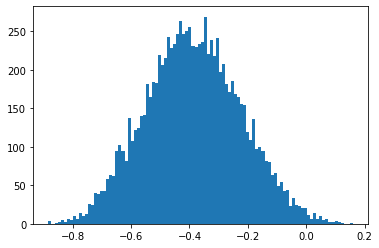

In [9]:
import scipy.stats

noise = np.random.rand(10000,NOISE_DIM)
generated_values = generator.predict(noise)
plt.hist(generated_values,bins=100)


true_gaussian = [np.random.randn() for x in range(10000)]

print('1st order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 1) , ', GAN :', scipy.stats.moment(generated_values,1))
print('2nd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 2) , ', GAN :', scipy.stats.moment(generated_values,2))
print('3rd order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 3) , ', GAN :', scipy.stats.moment(generated_values,3))
print('4th order moment - ', 'True : ', scipy.stats.moment(true_gaussian, 4) , ', GAN :', scipy.stats.moment(generated_values,4))
plt.show()

#### CONCLUSIONS

1. GANs are able to learn a generative model from arbitrary noise distributions.

2. Traditional GANs do not learn the higher-order moments well. Possible issues : Number of samples, approximating higher moments is hard. Usually known to under-predict higher order variances. For people interested in learning why, read more about divergence measures between distributions (particularly about Wasserstein etc.)

#### PLAY WITH IT WHEN YOU HAVE TIME !

1. Try different noise dimensions and see what minimum dimension you need to learn this well.
2. Try to generate multimodal distribution like a Gaussian Mixture instead of simple Gaussian and see if GAN is able to learn multimodal distributions well.

### EXERCISE 2 : MNIST GAN - Learn to generate MNIST digits

In [10]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Rescale data since we are using ReLU activations. <b>WHY ?</b>

In [11]:
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [12]:
z_dim = 100

#### BUILD MODEL

We are using LeakyReLU activations. 

We will build

a.) Generator
b.) Discriminator
c.) GAN

as feedforwards with multiple layers, dropout and LeakyReLU.

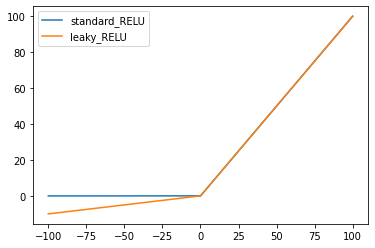

In [14]:
def leakyReLU(x,neg_scale=0.01):
  if x > 0:
    return x
  else:
    return neg_scale*x

std_relu = []
leaky_relu = []

std_relu = [leakyReLU(x,neg_scale=0) for x in np.linspace(-100,100,10000)]
leaky_relu = [leakyReLU(x,neg_scale=0.1) for x in np.linspace(-100,100,10000)]

plt.plot(np.linspace(-100,100,10000),std_relu, label='standard_RELU')
plt.plot(np.linspace(-100,100,10000),leaky_relu, label='leaky_RELU')
plt.legend()
plt.show()

In [16]:
#@title
adam = Adam(lr=0.0002, beta_1=0.5)


#GENERATOR
g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#DISCRIMINATOR
d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

#GAN
d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Let us write some visualization code.

In [17]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

<b> TRAIN THE MODEL </b>

Generate noise, feed into generator, compare them with discriminator, train the GAN and REPEAT.

In [20]:
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


--------------- Epoch 1 ---------------


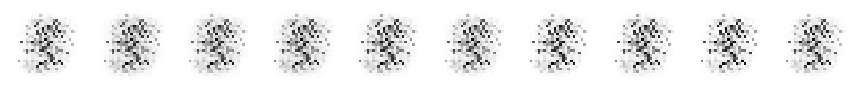

--------------- Epoch 40 ---------------


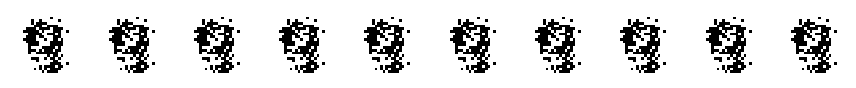

--------------- Epoch 80 ---------------


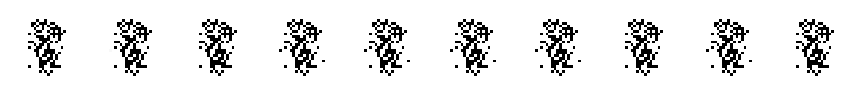

--------------- Epoch 120 ---------------


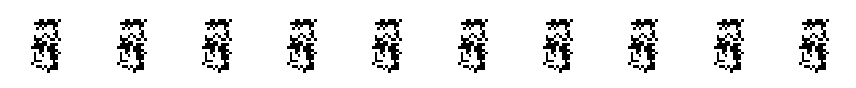

--------------- Epoch 160 ---------------


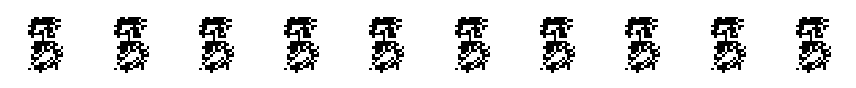

--------------- Epoch 200 ---------------


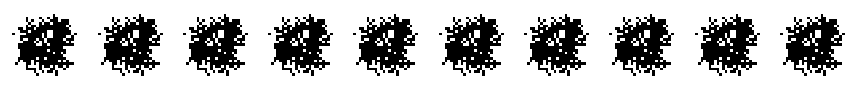

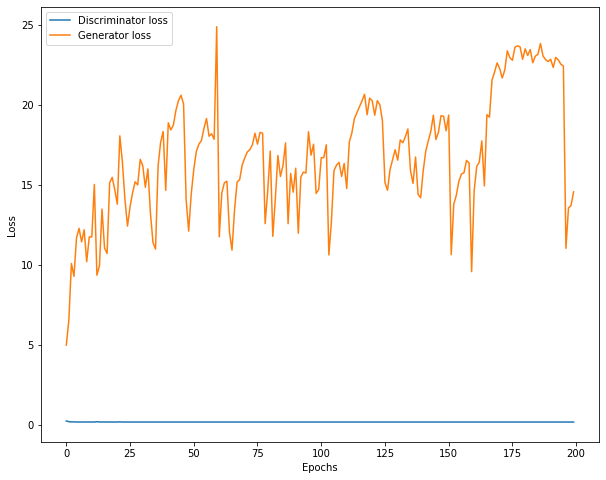

In [21]:
train(epochs=200, plt_frq=40, BATCH_SIZE=128)

#### TAKE-HOME EXERCISE

1. Try to build CNN models instead of feedforwards
2. Try different noise dimensions
3. Try implementing some training tricks suggested in https://github.com/soumith/ganhacks and study incremental improvements.

#### DISCUSSION : Why can GANs potentially mode collapse ? Remember there is no guarantee of mode collapse.



#### TL;DR - There is inherently no "motivation" for generator to produce a diverse set of samples as discriminator only penalizes for producing "bad" samples. It is easy to learn a few modes than all modes of a multi modal distribution.

Remember, the goal of the generator G is to fool the discriminator by causing it to assign the generated sample the highest probability of being real as possible. Mathematically, G tries to minimize E_z∼p_z(z)[log(1−D(G(z)))], or in other words, to generate the point x*=G(z) such that x*=argmax_x D(x) (of course, we’re assuming that we hold the discriminator fixed for now; we’re merely describing the optimization objective at a given timestep). Note that this x* is fixed regardless of the value of z, the input to the generator! x* only depends on the discriminator at the given timestep. This means that on expectation, there exists a single fixed point that the generator thinks is the most optimal point to generate regardless of whatever input noise we feed it - there is nothing in the objective function that explicitly forces the generator to generate different samples given the input. During this training step, stochastic gradient descent - again, on expectation - would cause the generator to update its weights towards generating this ideal point.

This by itself doesn’t immediately mean mode collapse; during the entirety of the training process, mode collapse may happen only partially or not at all. Since training is a stochastic process, during the beginning stages in training the generated samples will vary depending on z and the samples drawn from the real distribution will also vary - this means that gradients backpropagated to the generator will vary between training steps depending on the generated and real samples. Moreover the discriminator, ideally, should be able to identify generator mode collapse while it’s happening and assign the collapse point a low probability to force the generator to spread out. This is why we do see training runs succeed in GAN/DCGAN-based models.

But in practice, especially in default GAN models, mode collapse happens quite often. The discriminator ends up not really forcing more diversity in the generator, so much as simply pushing the partially collapsed generator to a different part of output space - if it assigns the collapse point a low probability, the generator will simply move its collapsed distribution to focus on a new output point. And finally, in the case where the generator has actually collapsed to a single point, it can’t get out; you’ll have to restart your training. To see why this is the case, remember how I said above that the gradient updates to the generator are stochastic, because its generated outputs will vary based on z. Well, in the world where the generator is already collapsed, it will emit the same output for every z. This means that if you feed a batch of generator outputs to the discriminator and get the gradients back, the generator gradients will all essentially be identical. And they’ll all be racing towards the same maximum point x*! Which means the generator will continue to generate the same output regardless of input. Even if the discriminator identifies this and sets the point to low probability, still, the identical gradient updates will cause all outputs of the generator rushing to another fixed point. At this point your training is ruined.


Thanks : This version of the answer is from https://www.quora.com/What-causes-mode-collapse-in-GANs

In [ ]:
33
10
23
44

1.5
45000
10
1900

18160
16000



